In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp

from qubic.lib.MapMaking.Qatmosphere_2d import AtmosphereMaps

import yaml

import qubic
from qubic.lib.Instrument.Qacquisition import QubicAcquisition
from qubic.lib.Instrument.Qinstrument import QubicInstrument
from qubic.lib.Qscene import QubicScene
from qubic.lib.Qsamplings import get_pointing, equ2gal

from qubic.lib.MapMaking.Qmaps import InputMaps

from qubic.lib.MapMaking.Qcg import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import MPI, BlockColumnOperator, BlockDiagonalOperator, DiagonalOperator, ReshapeOperator

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline 

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 

In [3]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)
qubic_dict = atm.qubic_dict

300


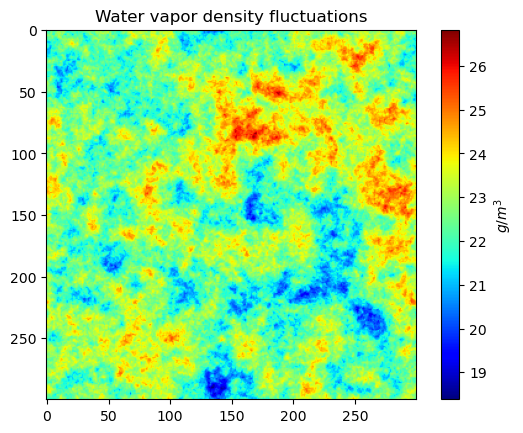

In [4]:
wv_fluctuations = atm.rho_map
print(wv_fluctuations.shape[0])
plt.imshow(wv_fluctuations, cmap='jet')
plt.title('Water vapor density fluctuations')
plt.colorbar(label=r'$g/m^{3}$')

In [5]:
atm.frequencies

array([134.05713053, 139.79146751, 145.7710926 , 152.00649808,
       158.50862505, 165.28888259, 196.61712478, 205.02748568,
       213.79760248, 222.94286386, 232.47931674, 242.42369446])

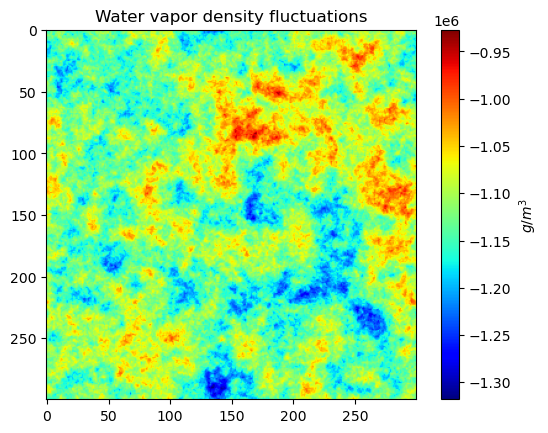

In [6]:
temp_fluctuations = np.zeros((wv_fluctuations.shape[0], wv_fluctuations.shape[1], 3))
temp_fluctuations[..., 0] = atm.get_temp_maps(wv_fluctuations)[0]
temp_fluctuations[..., 0] -= np.mean(temp_fluctuations[:, 0])

plt.imshow(temp_fluctuations[..., 0], cmap='jet')
plt.title('Water vapor density fluctuations')
plt.colorbar(label=r'$g/m^{3}$')

316.44761928968586 -58.75808063333319


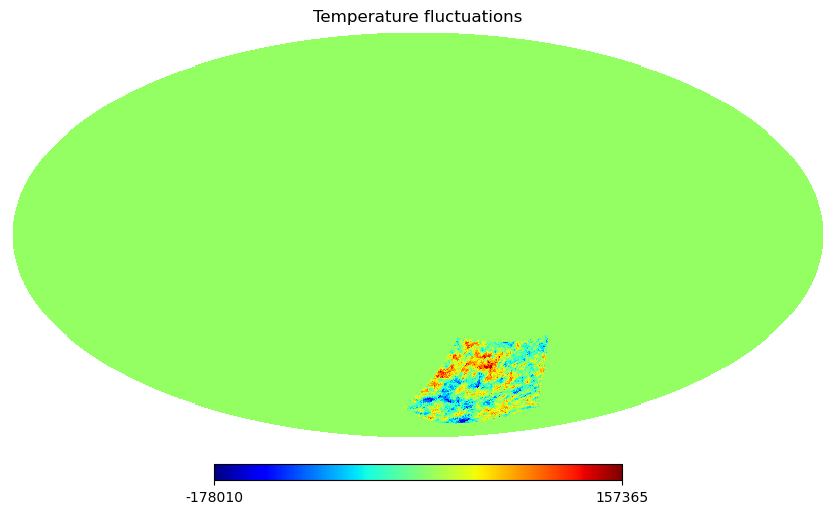

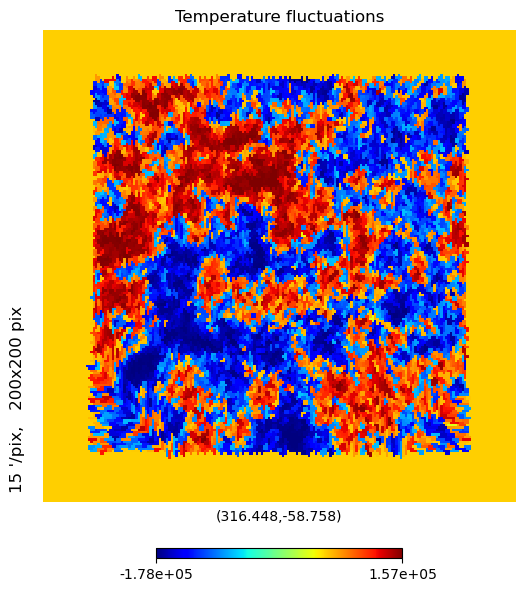

In [25]:
healpy_temp_fluctuations = np.zeros((hp.nside2npix(params['nside']), 3))
healpy_temp_fluctuations[..., 0] = atm.get_healpy_atm_maps_2d(atm.get_temp_maps(wv_fluctuations))[0]

index = np.where(healpy_temp_fluctuations!=0)[0]
healpy_temp_fluctuations[index, 0] -= np.mean(healpy_temp_fluctuations[index, 0])
min = np.min(healpy_temp_fluctuations[index, 0])
max = np.max(healpy_temp_fluctuations[index, 0])

hp.mollview(healpy_temp_fluctuations[..., 0], min=min, max=max, cmap='jet', title='Temperature fluctuations')
hp.gnomview(healpy_temp_fluctuations[..., 0], min=min, max=max, rot=equ2gal(0, -57), norm='hist', reso=15, cmap='jet', title='Temperature fluctuations')

In [8]:
print('Angular speed', qubic_dict['angspeed'])
print('Delta azimtuh', qubic_dict['delta_az'])
print('Sweeps per elevation', qubic_dict['nsweeps_per_elevation'])
print('latitude', qubic_dict['latitude'])
print('longitude', qubic_dict['longitude'])
print('Fix_azimuth', qubic_dict['fix_azimuth'])
print('period', qubic_dict['period'])
print('duration', qubic_dict['duration'])
print('Observation date', qubic_dict['date_obs'], type(qubic_dict['date_obs']))

Angular speed 0.4
Delta azimtuh 20
Sweeps per elevation 1
latitude -24.183333333333334
longitude -66.46666666666667
Fix_azimuth {'apply': False, 'az': 50, 'el': 50, 'el_step': 1, 'fix_hwp': True, 'fix_pitch': True}
period 1
duration 20
Observation date 2016-01-01 00:00:00 <class 'str'>


In [9]:
### Random pointing
qubic_dict['random_pointing'] = False

### Sweepingpointing
qubic_dict['sweeping_pointing'] = True
qubic_dict['fix_azimuth']['apply'] = False 
qubic_dict['duration'] = 1
qubic_dict['period'] = 10

### Repeat pointing
qubic_dict['repeat_pointing'] = False

q_sampling = get_pointing(qubic_dict)
print(q_sampling)

QubicSampling((360,), 
    index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 ,
    angle_hwp=[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 15. 15. 15. 15. 15. 15. ,
    azimuth=[197.50277742 201.52484555 205.54688157 209.56888532 213.5908569
,
    elevation=[49.14565013 49.14565013 49.14565013 49.14565013 49.14565013 49.1,
    equatorial=[[  9.26068069 -61.51696127]
 [  5.09388936 -59.87912895]
 [  1.5,
    galactic=[[305.96347064 -55.52647567]
 [310.0487557  -56.81784832]
 [314.2,
    masked=False,
    pitch=[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.)


Text(0, 0.5, 'Elevation (degrees)')

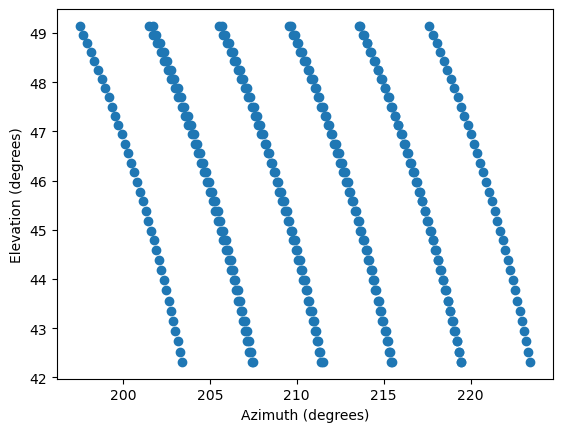

In [10]:
plt.plot(q_sampling.azimuth, q_sampling.elevation, 'o')
plt.xlabel('Azimuth (degrees)')
plt.ylabel('Elevation (degrees)')

In [11]:
from pysimulators.interfaces.healpy import Spherical2HealpixOperator
from pysimulators import SphericalHorizontal2EquatorialOperator, SphericalEquatorial2GalacticOperator
from pyoperators.utils import isscalarlike
from astropy.time import Time, TimeDelta

def _format_sphconv(a, b, date_obs=None, time=None):
    incoords = np.empty(np.broadcast(a, b).shape + (2,))
    incoords[..., 0] = a
    incoords[..., 1] = b
    if date_obs is None:
        return incoords
    print('time', Time(date_obs, scale='utc'))
    print('delta time', TimeDelta(time, format='sec'))
    time = Time(date_obs, scale='utc') + TimeDelta(time, format='sec')
    return incoords, time

incoords, time = _format_sphconv(q_sampling.azimuth, q_sampling.elevation, date_obs=qubic_dict['date_obs'], time=q_sampling.time)
h2e = SphericalHorizontal2EquatorialOperator(
        'NE', time, qubic_dict['latitude'], qubic_dict['longitude'], degrees=True)
e2g = SphericalEquatorial2GalacticOperator(degrees=True)
outcoords = e2g(h2e(incoords))

time 2016-01-01 00:00:00.000
delta time [   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.
  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.
  360.  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.
  480.  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.
  600.  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.
  720.  730.  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.
  840.  850.  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.
  960.  970.  980.  990. 1000. 1010. 1020. 1030. 1040. 1050. 1060. 1070.
 1080. 1090. 1100. 1110. 1120. 1130. 1140. 1150. 1160. 1170. 1180. 1190.
 1200. 1210. 1220. 1230. 1240. 1250. 1260. 1270. 1280. 1290. 1300. 1310.
 1320. 1330. 1340. 1350. 1360. 1370. 1380. 1390. 1400. 1410. 1420. 1430.
 1440. 1450. 1460. 1470. 1480. 1490. 1500. 1510. 1520. 1530. 1540. 1550.
 1560. 1570

360


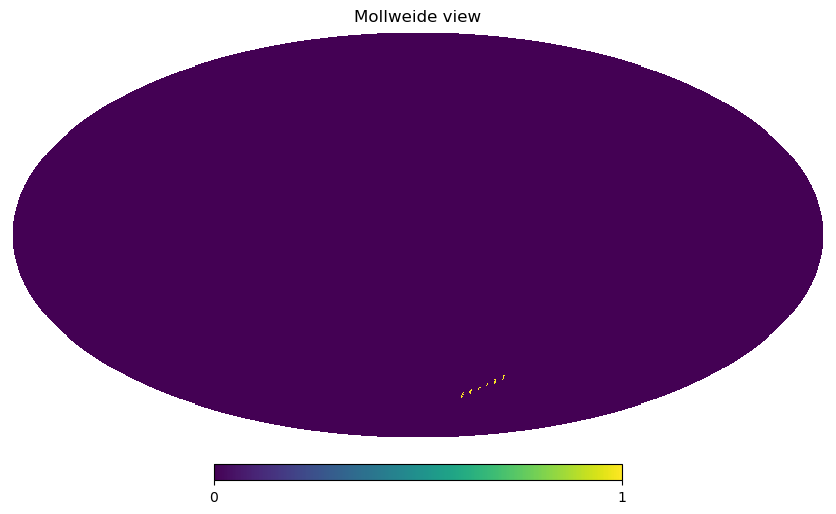

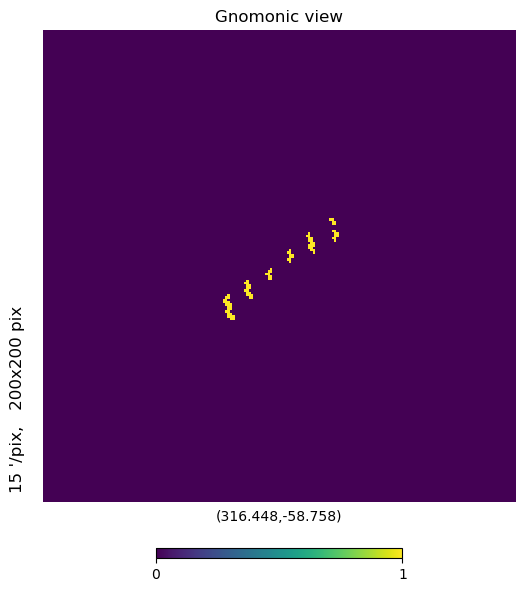

In [12]:
test = np.zeros(hp.nside2npix(params['nside']))
azel = np.asarray([q_sampling.azimuth, q_sampling.elevation]).T
index = np.array(Spherical2HealpixOperator(params['nside'], 'azimuth, elevation')(np.radians(outcoords)), dtype='int')
test[index] = 1
print(len(index))
hp.mollview(test)
hp.gnomview(test, rot=equ2gal(0, -57), reso=15)

In [13]:
q_instrument = QubicInstrument(qubic_dict)
q_scene = QubicScene(qubic_dict)

q_acquisition = QubicAcquisition(q_instrument, q_sampling, q_scene, qubic_dict)

In [14]:
coverage = q_acquisition.get_coverage()

covnorm = coverage / coverage.max()
seenpix = covnorm > params['coverage_cut']

center = np.array([0, -57])
qubic_patch = qubic.lib.Qsamplings.equ2gal(center[0], center[1])

Info apcnb2325: Allocating (357120,9) elements = 49.04296875 MiB in FSRRotation3dMatrix.__init__.


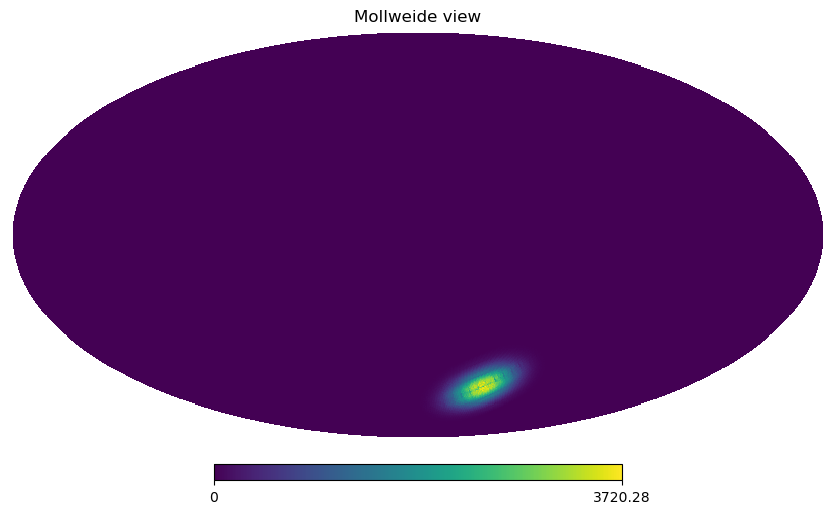

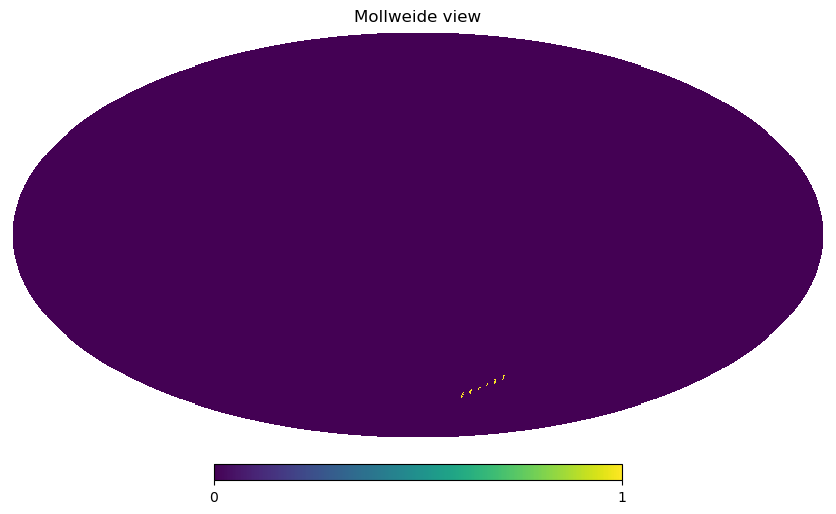

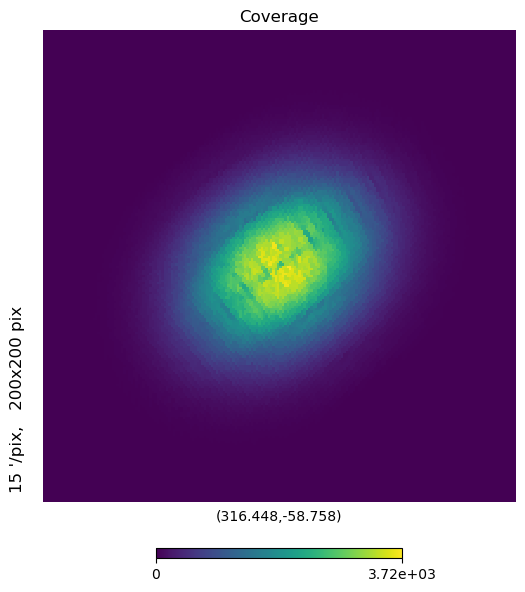

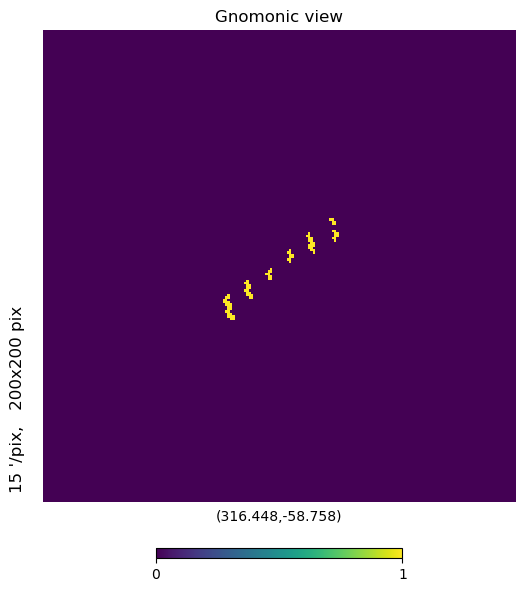

In [15]:
hp.mollview(coverage)
hp.mollview(test)
hp.gnomview(coverage, rot=equ2gal(0, -57), reso=15, title='Coverage')
hp.gnomview(test, rot=equ2gal(0, -57), reso=15)

In [16]:
H_qubic = q_acquisition.get_operator()
R_qubic = ReshapeOperator(H_qubic.shapeout, H_qubic.shape[0])
invN_qubic = R_qubic(q_acquisition.get_invntt_operator(False, False)(R_qubic.T))
d_qubic = H_qubic(healpy_temp_fluctuations).ravel()

Info apcnb2325: Allocating (357120,9) elements = 49.04296875 MiB in FSRRotation3dMatrix.__init__.


In [17]:
H = R_qubic(H_qubic)
invN = invN_qubic
d = d_qubic

In [18]:
A = H.T * invN * H
b = H.T * invN * d.flatten()
x0 = healpy_temp_fluctuations*0
true_maps = healpy_temp_fluctuations

In [19]:
stacked_dptdp_inv = np.zeros((1,12*params['nside']**2))

D = H.operands[2]
P = H.operands[-1]
sh = P.matrix.data.index.shape
no_det = 992
point_per_det = int(sh[0] / no_det)
mapPtP_perdet_seq = np.zeros((no_det, 12 * params['nside']**2))
sample_ranges = [(det * point_per_det, (det + 1) * point_per_det) for det in range(no_det)]
for det, (start, end) in enumerate(sample_ranges):
    indices = P.matrix.data.index[start:end, :]  
    weights = P.matrix.data.r11[start:end, :]
    flat_indices = indices.ravel()
    flat_weights = weights.ravel()

    mapPitPi = np.zeros(12 * params['nside']**2)
    np.add.at(mapPitPi, flat_indices, flat_weights**2)

    mapPtP_perdet_seq[det, :] = mapPitPi
D_elements = D.data
D_sq = D_elements**2
mapPtP_seq_scaled = D_sq[:, np.newaxis] * mapPtP_perdet_seq 
dptdp = mapPtP_seq_scaled.sum(axis = 0)
dptdp_inv = 1 / dptdp
dptdp_inv[np.isinf(dptdp_inv)] = 0.
stacked_dptdp_inv[0] = dptdp_inv
M = BlockDiagonalOperator( \
            [DiagonalOperator(ci, broadcast='rightward') for ci in stacked_dptdp_inv],
            new_axisin=0)

In [20]:
# Run PCG
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-10,
    maxiter=200,
    disp=True,
    M=M,
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

2
 Iter     Tol      time
   1: 3.1102e-01 0.02822 [ 8569.32843245 11388.07691361 30253.88602328 ... 24790.62218527
  5477.79032215 12829.01382236]
2
   2: 1.8859e-01 0.02465 [ 2291.49876538 13557.76120151 22684.28240096 ... 26426.01239353
 11760.32017589 17007.69976574]
2
   3: 9.1016e-02 0.02417 [ 2111.9413205  14035.72575863 16689.01100327 ... 23178.89093886
 10731.66371728 17333.89701085]
2
   4: 5.6943e-02 0.02445 [ 7204.63635271 15754.60179948 13835.4662657  ... 18805.79880314
  7228.30325564 20209.52689191]
2
   5: 4.7900e-02 0.02399 [ 8962.72701236 13993.09875611 10836.31133009 ... 15507.21693855
  5973.76886795 18634.2528484 ]
2
   6: 2.9639e-02 0.02439 [11621.35287188 12452.30972525  9602.28099853 ... 15285.48338652
  7508.1264179  18342.83979337]
2
   7: 2.3544e-02 0.02386 [13857.75429082 11592.57154838  9074.90841743 ... 12752.88337935
  6496.52774222 16247.54173212]
2
   8: 1.8295e-02 0.02460 [13796.13754787  9558.77928883  7274.63615774 ... 10812.7426147
  6150.87837035 1

Text(0, 0.5, 'Convergence')

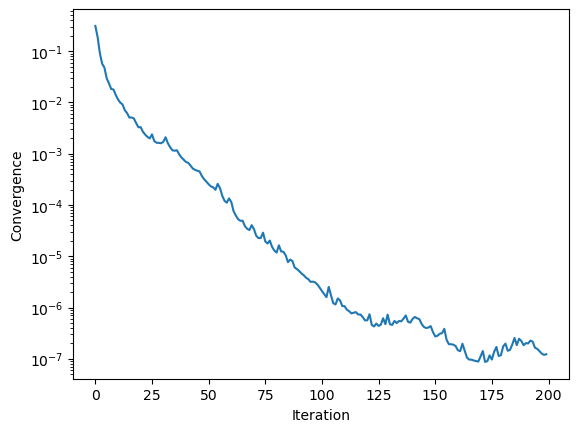

In [21]:
plt.plot(output['convergence'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

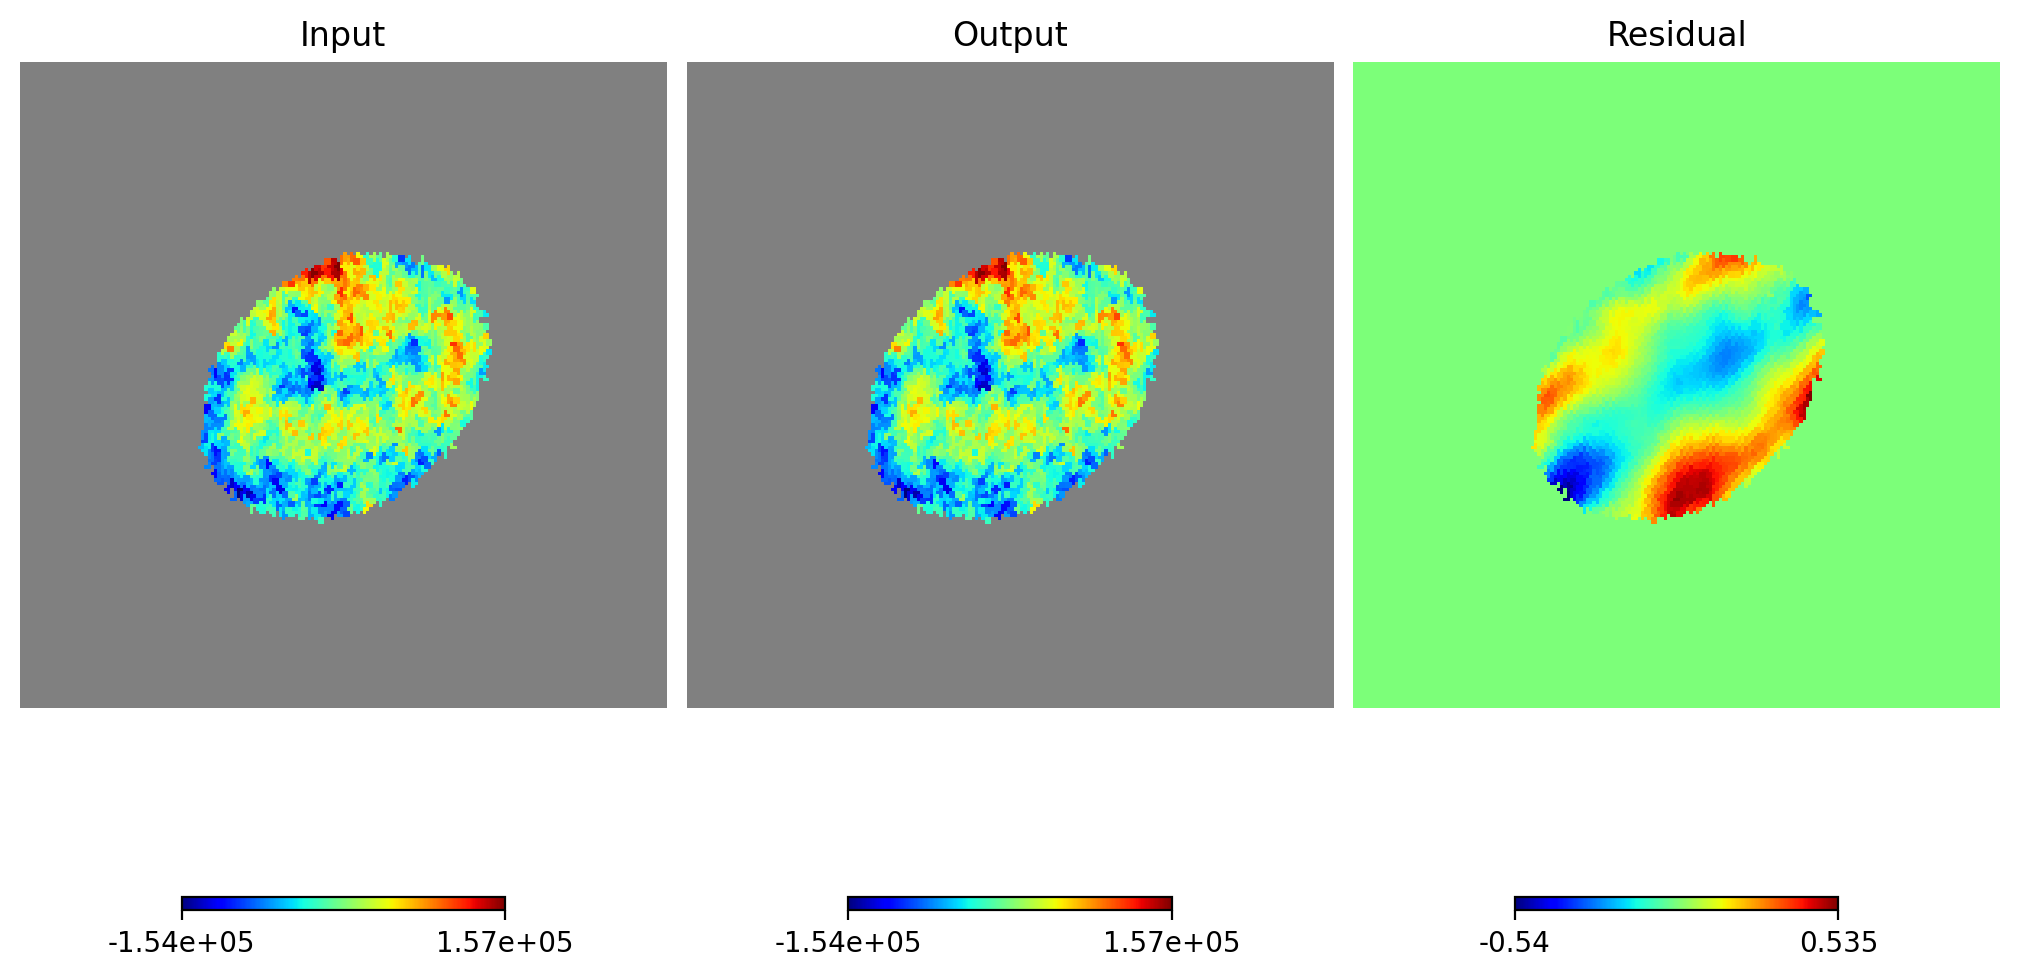

In [22]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

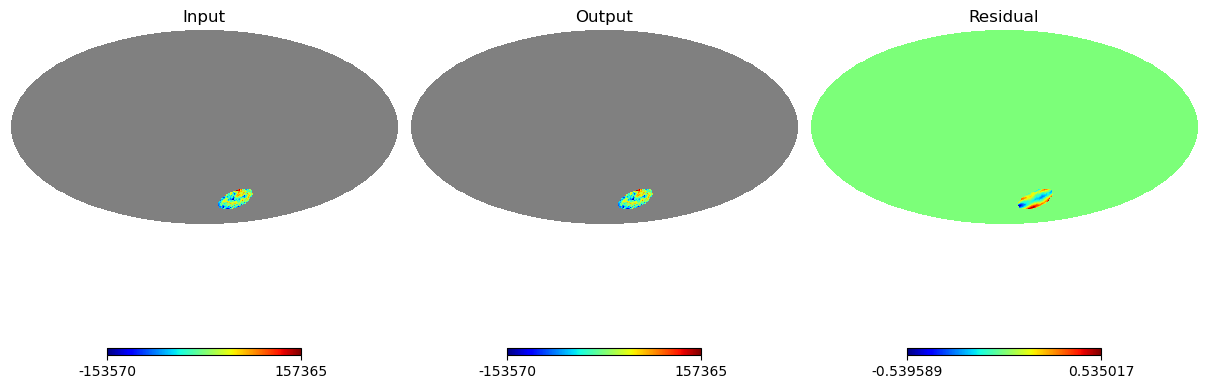

In [23]:
plt.figure(figsize=(12, 25))
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.mollview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k), title='Input', notext=True)
hp.mollview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k+1), title='Output', notext=True)
hp.mollview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

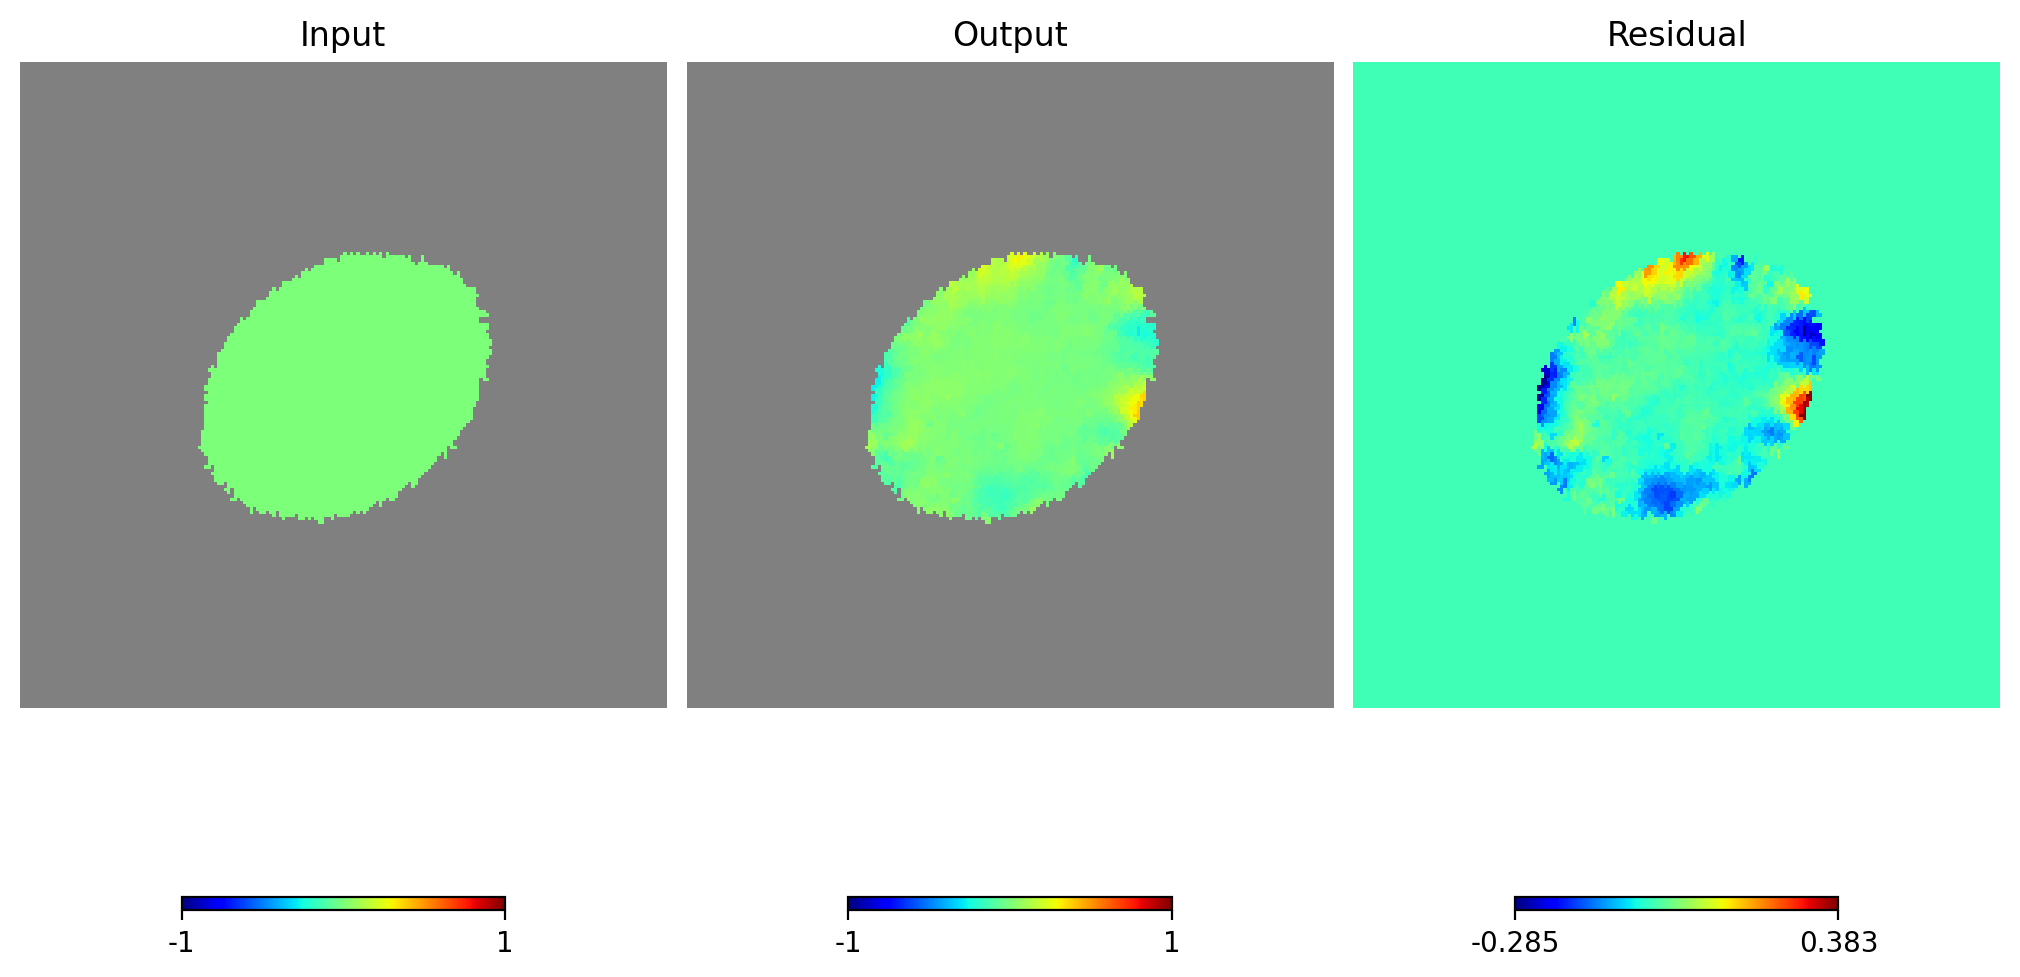

In [24]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 1
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

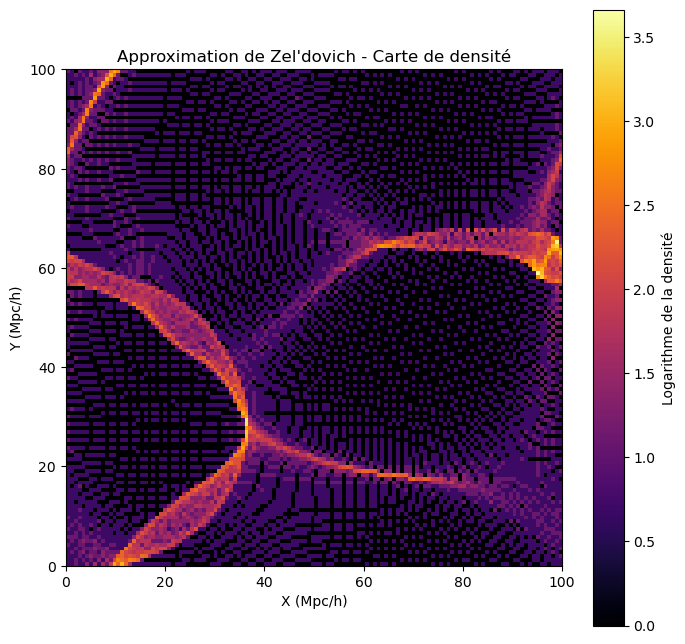

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


box_size = 100.0  
grid_size = 128  
scale_factor = 1.0 
final_scale_factor = 500.0  
steps = 100  

def generate_gaussian_random_field_2d(grid_size, power_spectrum):

    k = np.fft.fftfreq(grid_size, d=box_size / grid_size) * 2 * np.pi
    kx, ky = np.meshgrid(k, k, indexing="ij")
    k_squared = kx**2 + ky**2
    k_squared[0, 0] = 1 
    
    amplitude = np.sqrt(power_spectrum(k_squared) / 2)
    phases = np.random.normal(0, 1, (grid_size, grid_size)) \
             + 1j * np.random.normal(0, 1, (grid_size, grid_size))
    return np.fft.ifftn(amplitude * phases).real

def power_spectrum_2d(k_squared):

    k = np.sqrt(k_squared)
    k[k == 0] = 1e-10 
    return k**-3 * np.exp(-k**2 / (0.1**2))

linspace = np.linspace(0, box_size, grid_size, endpoint=False)
x, y = np.meshgrid(linspace, linspace, indexing="ij")
positions = np.array([x.ravel(), y.ravel()]).T

delta = generate_gaussian_random_field_2d(grid_size, power_spectrum_2d)
k = np.fft.fftfreq(grid_size, d=box_size / grid_size) * 2 * np.pi
kx, ky = np.meshgrid(k, k, indexing="ij")

displacement_x = np.fft.ifftn(-1j * kx * np.fft.fftn(delta)).real
displacement_y = np.fft.ifftn(-1j * ky * np.fft.fftn(delta)).real

displacement = np.array([displacement_x, displacement_y])

a_values = np.linspace(scale_factor, final_scale_factor, steps)
for a in a_values:
    positions += a * displacement.reshape(2, grid_size, grid_size).reshape(2, -1).T
    positions %= box_size  

density, _, _ = np.histogram2d(positions[:, 0], positions[:, 1], bins=grid_size, range=[[0, box_size], [0, box_size]])

plt.figure(figsize=(8, 8))
plt.imshow(np.log1p(density), origin='lower', extent=[0, box_size, 0, box_size], cmap='inferno')
plt.colorbar(label='Logarithme de la densité')
plt.xlabel("X (Mpc/h)")
plt.ylabel("Y (Mpc/h)")
plt.title("Approximation de Zel'dovich - Carte de densité")
plt.show()


In [40]:
positions.shape

(16384, 2)